# Perth Weather Consumer - Graph

The following consumer will consumer the message and plot two graphs: 
1. The average temperature in Perth over the past x hours
2. The top 3 frequent weather text in Perth over the past x hours.

In [1]:
# import statements
import datetime as dt
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
from json import loads
import datetime
import statistics
from collections import Counter

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

In [2]:
# Define the topic name
topic = "Perth"

def connect_kafka_consumer():
    _consumer = None
    
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=100000, # stop iteration if no message after 100 sec
                                   auto_offset_reset='latest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   value_deserializer = lambda x: loads(x.decode("ascii")),
                                   api_version=(0, 10))
    
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    
    finally:
        return _consumer    
    
    
def init_plots():
    
    try:
        # Create empty plot with the predefined width and height
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height))
        fig.subplots_adjust(hspace=0.8)
        
        # Create one plot and define the x and y label
        ax1 = fig.add_subplot(211)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Temperature')
        
        # Create a second plot plot and define the x and y label      
        ax2 = fig.add_subplot(212)
        ax2.set_xlabel('WeatherText')
        ax2.set_ylabel('Count')
        
        # giving figure a title        
        fig.suptitle('Weather in Perth')         
        # displaying the figure
        fig.show() 
        # drawing on the canvas
        fig.canvas.draw() 
        
        return fig, ax1, ax2
    
    except Exception as ex:
        print(str(ex))    
        

def find_top_frequent(a_list, top_frequency):
    
    # Count the occurrence of each element. 
    a_dict = Counter(a_list)
    
    # Sort the occurrence from the largest to the smallest
    sorted_list = sorted(a_dict.items(), key = lambda x: x[1], reverse=True)
    
    # Finding the cut-off point of the occurrence of the third frequent weather text. 
    threshold = sorted_list[:top_frequency][-1][1]
    
    sorted_dict = []
    
    # Collect data for the bar chart
    for i in sorted_list:
        if i[1] < threshold: 
            break
        else:
            sorted_dict.append(i)
    
    # Convert back to a dictionary
    sorted_dict = dict(sorted_dict)
            
    return sorted_dict    

<IPython.core.display.Javascript object>


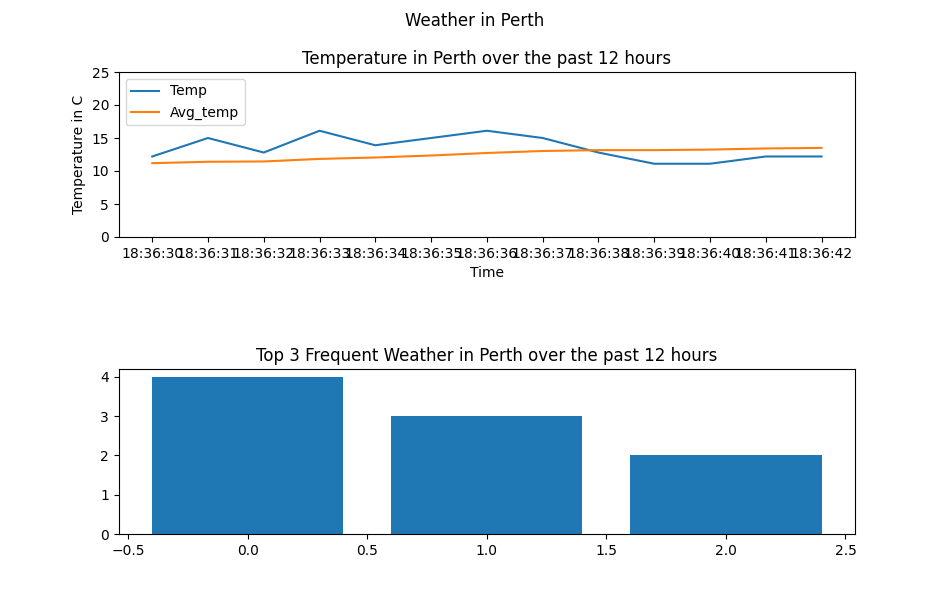

<ipython-input-3-599b2dcb0fc3>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x, rotation=45)


KeyboardInterrupt: 

In [3]:
def consume_messages(consumer,fig, ax1, ax2):
    
    x_limit = 12
    top_frequency = 3
    
    try:
        # container for x and y values
        x, y1, y2 = [], [], []
        X = []
        
        for message in consumer:
            
            # Gather data from the consumer for analysing temperature
            x.append(message.value["Time"])
            y1.append(message.value["Temperature"]["Metric"]["Value"])    # Look into temperature in Celsius only
            
            # Gather data from the consumer for analysisng weather text
            X.append(message.value["WeatherText"])
            X = [each_X.strip().lower() for each_X in X]    # Lowercase the weather text string
            X_dict = find_top_frequent(X, top_frequency)    # Collect top frequent weather text string

            # Calculating the average weather for the past x hours. 
            if len(y1) >= 1:
                y2.append(statistics.mean(y1[:len(y1)]))
            else:
                y2.append()
            
            # Plot graph
            if len(x) > x_limit:
                
                # Draw lines, axis, title and legend for analysing temperature
                ax1.clear()
                ax1.plot(x,y1, label = "Temp")
                ax1.plot(x, y2, label = "Avg_temp")
                ax1.set_title("Temperature in Perth over the past " + str(x_limit) + " hours")
                ax1.set_ylim(0,25)
                ax1.set_xlabel('Time')
                ax1.set_ylabel('Temperature in C')
                ax1.legend(loc = "upper left")

                # Draw lines, axis, title and legend for analysing weather text
                ax2.clear()
                ax2.bar(*zip(*X_dict.items()))
                ax2.set_title("Top 3 Frequent Weather in Perth over the past " + str(x_limit) + " hours")
                ax2.set_xlabel('Weather Text')
                ax2.set_ylabel('Count')
                
                ax1.set_xticklabels(x, rotation=45)
                
                fig.canvas.draw()
                
                # Remove excessive value
                x.pop(0) 
                y1.pop(0)
                y2.pop(0)
                X.pop(0)
            
            else:
                print("Collecting data for graph-ploting...")
                
        plt.close('all')
        
    except Exception as ex:
        print(str(ex))
        
        
if __name__ == '__main__':
    
    # Initialise consumer
    consumer = connect_kafka_consumer()
    
    # Plot empty plot
    fig, ax1, ax2 = init_plots()
    
    # Consume the message
    consume_messages(consumer, fig, ax1, ax2)
